# Evaluate Models
Load a trained model and evaluate it:
- visually
- 

In [36]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2 as tv_transforms
from torchvision.transforms.v2.functional import to_pil_image

from models.fcn_factory import FcnFactory
from preprocess.datasets import make_hou_dataset
import preprocess.transforms as custom_transforms

#### Load Model and Test Dataset

In [2]:
# model_path = 'saved_models/model_20240324_152229_4'
model_path = 'saved_models/model_20240328_074804_4'
test_ds_path = 'saved_models/test_data/test_ds_20240328_074804.pkl'

In [3]:
factory = FcnFactory(n_classes=2)
model_ut = factory.make_fcn('resnet50')
model_ut.load_state_dict(torch.load(model_path))
model_ut.eval()
print() # prevent the model being printed, since it is returned from `eval()`

In [44]:
print(factory.input_transforms)

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
with open(test_ds_path, 'rb') as f:
    test_ds = pickle.load(f)
type(test_ds)

torch.utils.data.dataset.Subset

In [102]:
test_loader = DataLoader(test_ds)
iter_loader = iter(test_loader)

In [125]:
example_img, example_mask = next(iter_loader)

In [126]:
example_output = model_ut(example_img)['out'].detach()

In [127]:
def predict(raw_output: torch.Tensor) -> torch.BoolTensor:
    return (torch.softmax(raw_output, dim=1) > 0.5).float()

In [128]:
example_pred = predict(example_output)

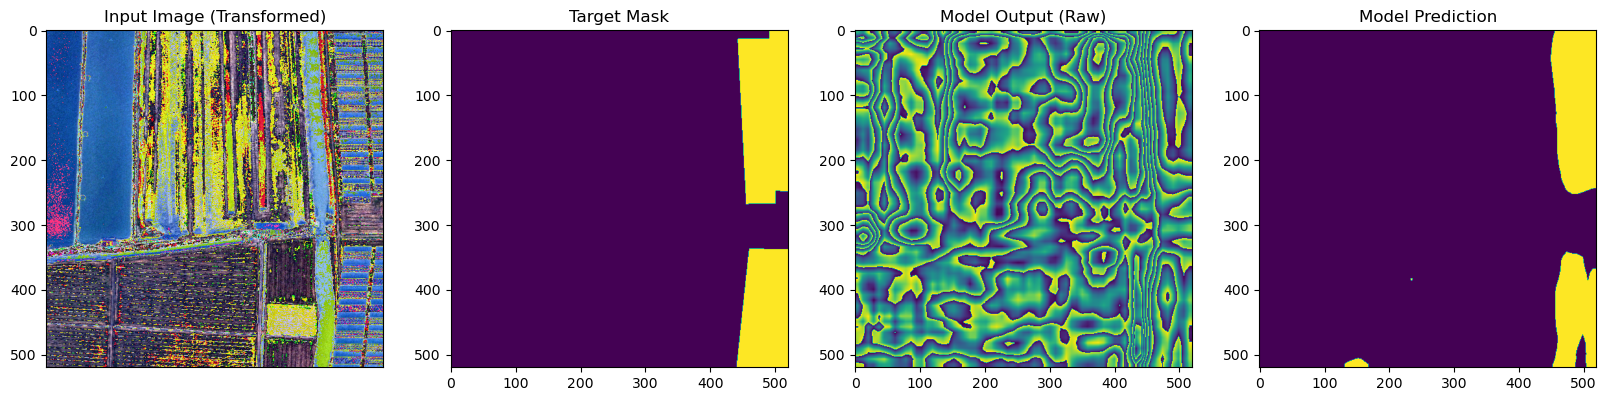

In [129]:
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
ax[0].imshow(to_pil_image(example_img[0]))
ax[0].set_title('Input Image (Transformed)')
ax[0].set_xticks([])
ax[1].imshow(to_pil_image(example_mask[0, 1, :, :]))
ax[1].set_title('Target Mask')
ax[2].imshow(to_pil_image(example_output[0, 1, :, :]))
ax[2].set_title('Model Output (Raw)')
ax[3].imshow(to_pil_image(example_pred[0, 1, :, :]))
ax[3].set_title('Model Prediction')
plt.show()

In [81]:
def show_img(ax, img: Image.Image, title: str) -> None:
    ax.imshow(img)
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

In [82]:
input_img = Image.open('data/Hou/PV03_Ground_Cropland/PV03_333271_1197538.png')

In [83]:
def intersection(target: torch.Tensor, pred: torch.Tensor) -> Image.Image:
    return to_pil_image(torch.logical_and(target, pred).float())

def union(target: torch.Tensor, pred: torch.Tensor) -> Image.Image:
    return to_pil_image(torch.logical_or(target, pred).float())


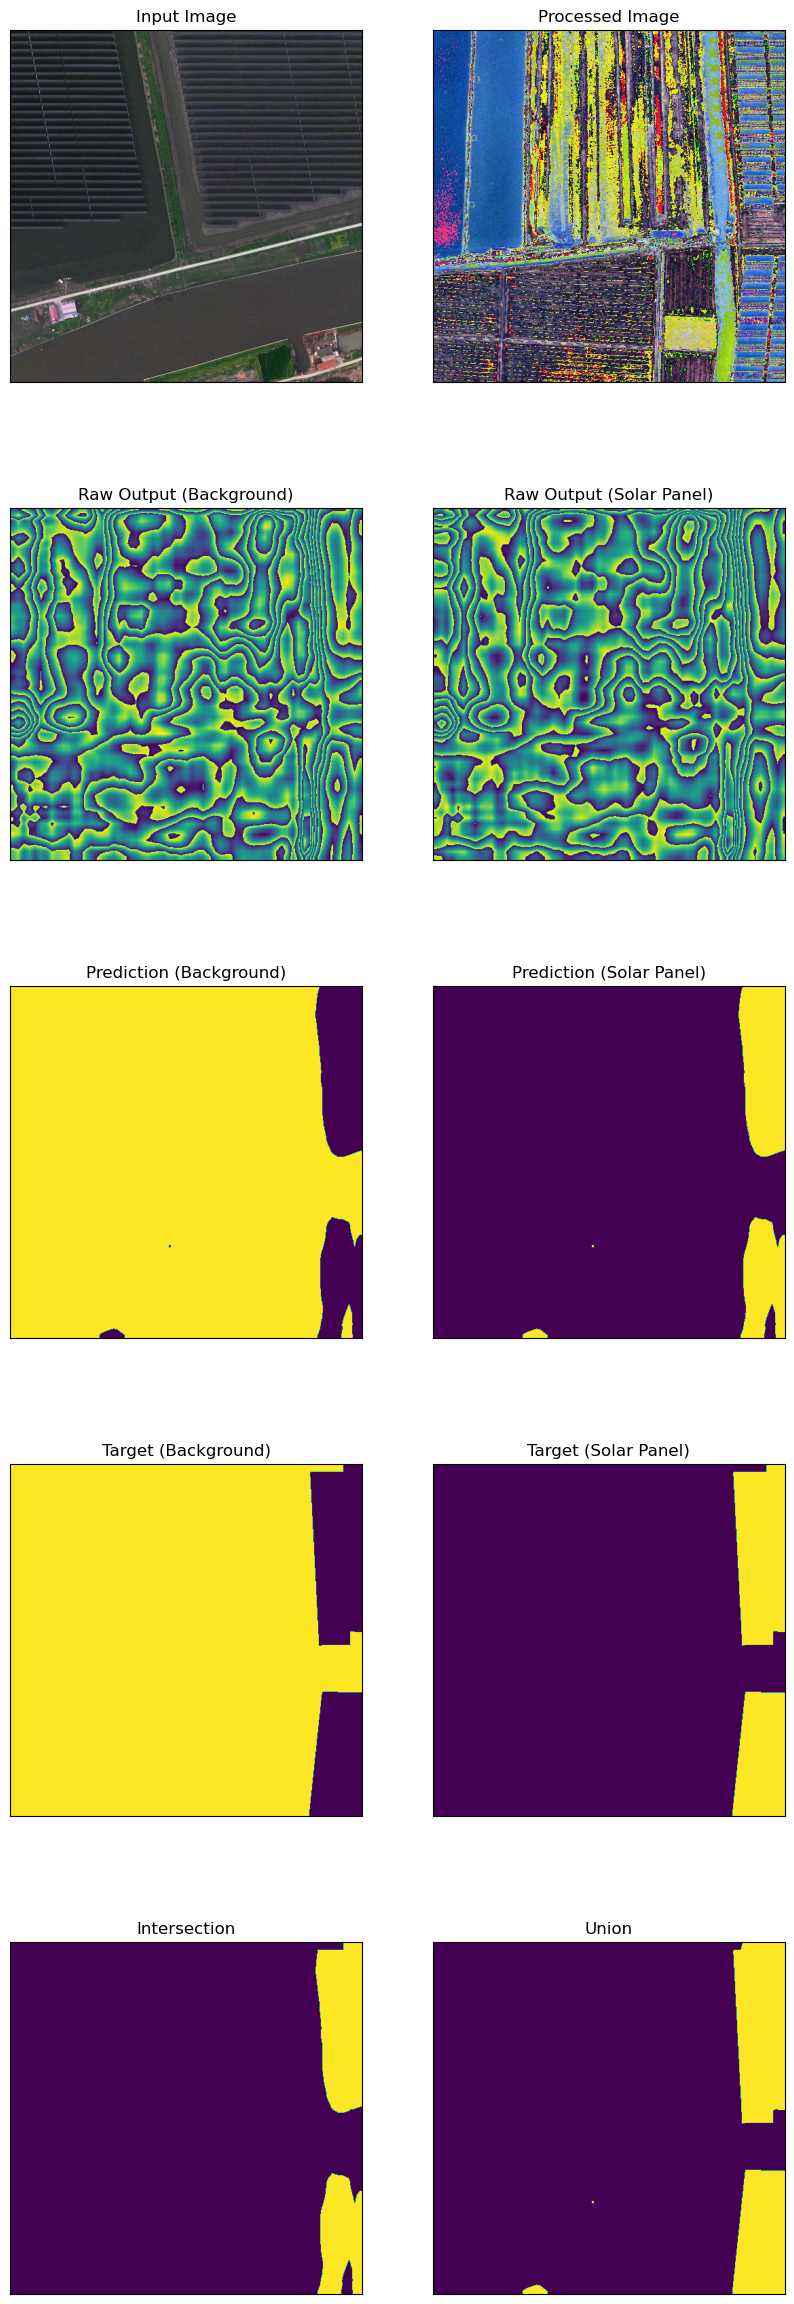

In [130]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))
show_img(ax[0][0], input_img, 'Input Image')
show_img(ax[0][1], to_pil_image(example_img[0]), 'Processed Image')
show_img(ax[1][0], to_pil_image(example_output[0, 0]), 'Raw Output (Background)')
show_img(ax[1][1], to_pil_image(example_output[0, 1]), 'Raw Output (Solar Panel)')
show_img(ax[2][0], to_pil_image(example_pred[0, 0]), 'Prediction (Background)')
show_img(ax[2][1], to_pil_image(example_pred[0, 1]), 'Prediction (Solar Panel)')
show_img(ax[3][0], to_pil_image(example_mask[0, 0]), 'Target (Background)')
show_img(ax[3][1], to_pil_image(example_mask[0, 1]), 'Target (Solar Panel)')
show_img(ax[4][0], intersection(example_mask[0, 1], example_pred[0, 1]), 'Intersection')
show_img(ax[4][1], union(example_mask[0, 1], example_pred[0, 1]), 'Union')


In [31]:
def calc_iou(pred: np.array, target: np.array) -> float:
    """Calculate the IoU for a single sample"""
    intersection = np.sum(np.logical_and(pred, target))
    union = np.sum(np.logical_or(pred, target))
    # Check if union is zeros.
    if union == 0.:
        # This means that the prediction and output
        # are both all zeros.
        return 1.
    return intersection / union


def mean_iou(test_dataset_loader, model) -> float:
    """Calculate the mean IoU for all samples in test dataset"""
    total = 0.
    for input_img, mask in test_dataset_loader:
        prediction = predict(model(input_img)['out'])
        prediction = prediction.numpy()
        mask = mask.detach().numpy()
        iou = calc_iou(prediction[0, 1], mask[0, 1])
        assert not np.isnan(iou)
        total += iou
    return total / len(test_dataset_loader)

In [32]:
print(f'Mean IoU: {mean_iou(test_loader, model_ut):.2f}')

Mean IoU: 0.70


In [131]:
calc_iou(example_pred.numpy(), example_mask.numpy())

0.9467663088475633